# Laboratorio 5

- Gerson Ramirez 22281
- Diego Valenzuela 22309

In [1]:
import sys, os, re, json, math, string, collections
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import emoji

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)
print("nltk:", nltk.__version__)

# Descargar recursos NLTK (silencioso)
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)


Python: 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
pandas: 2.2.2
numpy: 1.26.4
matplotlib: 3.8.4
scikit-learn: 1.4.2
nltk: 3.8.1


True

## 1) Carga del dataset

In [2]:
DATA_PATH = Path("./train.csv")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"No se encontró {DATA_PATH}. Pon tu train.csv en esa ruta.")

df = pd.read_csv(DATA_PATH)
display(df.head())


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.info()
print("\nDistribución de la variable objetivo (target):")
print(df["target"].value_counts(dropna=False))

expected_cols = {"id", "keyword", "location", "text", "target"}
missing = expected_cols - set(df.columns)
if missing:
    print("ADVERTENCIA: Faltan columnas esperadas:", missing)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

Distribución de la variable objetivo (target):
target
0    4342
1    3271
Name: count, dtype: int64


# 2) Limpieza y preprocesamiento

Objetivo: normalizar el texto para análisis posterior.

Pasos aplicados:
- Pasar a minúsculas
- Remover URLs, menciones, el símbolo `#` (conservando la palabra)
- Remover dígitos y puntuación
- Normalizar/empaquetar emojis a texto (o eliminarlos)
- Colapsar espacios en blanco
- Tokenizar y filtrar *stopwords* (inglés por defecto en este dataset)

In [4]:
# Expresiones y tablas útiles
URL_RE = re.compile(r'https?://\S+|www\.\S+')
MENTION_RE = re.compile(r'@[A-Za-z0-9_]+')
HASHTAG_RE = re.compile(r'#')             
DIGIT_RE = re.compile(r'\d+')
PUNCT_TABLE = str.maketrans('', '', string.punctuation)

# Stopwords (inglés por defecto)
stop_en = set(stopwords.words('english'))
custom_stop = set([])  
stop_all = stop_en | custom_stop

def clean_text(s: str) -> str:
    """Limpieza mínima razonable para tweets."""
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = URL_RE.sub(' ', s)
    s = MENTION_RE.sub(' ', s)
    s = HASHTAG_RE.sub('', s)
    s = DIGIT_RE.sub(' ', s)
    s = emoji.replace_emoji(s, replace=' ')  
    s = s.translate(PUNCT_TABLE)             
    s = re.sub(r'\s+', ' ', s).strip()       
    return s

def tokenize_and_filter(s: str):
    """Tokeniza y filtra stopwords y tokens cortos."""
    toks = word_tokenize(s)
    toks = [t for t in toks if t not in stop_all and len(t) > 2]
    return toks


Aplicar limpieza y tokenización

In [5]:
df["text_clean"] = df["text"].apply(clean_text)
df["tokens"] = df["text_clean"].apply(tokenize_and_filter)
display(df[["text", "text_clean", "tokens"]].head(10))

,text,text_clean,tokens
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...,"[deeds, reason, earthquake, may, allah, forgive]"
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,"[forest, fire, near, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,"[residents, asked, shelter, place, notified, o..."
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...,"[people, receive, wildfires, evacuation, order..."
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."
5,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy closed in both...,"[rockyfire, update, california, hwy, closed, d..."
6,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain causes flash floodin...,"[flood, disaster, heavy, rain, causes, flash, ..."
7,I'm on top of the hill and I can see a fire in...,im on top of the hill and i can see a fire in ...,"[top, hill, see, fire, woods]"
8,There's an emergency evacuation happening now ...,theres an emergency evacuation happening now i...,"[theres, emergency, evacuation, happening, bui..."
9,I'm afraid that the tornado is coming to our a...,im afraid that the tornado is coming to our area,"[afraid, tornado, coming, area]"


# 3) Unigramas y n-gramas por clase

Calcularemos términos más frecuentes separando por `target`:
- `target = 0`: no desastre
- `target = 1`: desastre

Usaremos `CountVectorizer` (scikit-learn) para generar **unigramas** y **bigramas**.  
Parámetros clave:
- `ngram_range=(1,1)` para unigramas; `(2,2)` para bigramas
- `min_df`: ignora términos raros (aparecen en menos de `min_df` documentos)
- `topk`: número de términos a mostrar

In [6]:
def top_terms(series_of_docs, ngram=(1,1), topk=20, min_df=2):
    """
    Retorna un DataFrame con los términos y su frecuencia total.
    series_of_docs: pd.Series de documentos en texto limpio
    ngram: tupla (min_n, max_n)
    """
    vec = CountVectorizer(ngram_range=ngram, min_df=min_df)
    X = vec.fit_transform(series_of_docs)
    sums = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    order = np.argsort(-sums)
    return pd.DataFrame({"term": terms[order][:topk], "freq": sums[order][:topk]})


In [7]:
top_uni_0 = top_terms(df.loc[df.target == 0, "text_clean"], (1,1), topk=20, min_df=2)
top_uni_1 = top_terms(df.loc[df.target == 1, "text_clean"], (1,1), topk=20, min_df=2)

print("Top unigramas · Clase 0 (no desastre)")
display(top_uni_0)

print("Top unigramas · Clase 1 (desastre)")
display(top_uni_1)


Top unigramas · Clase 0 (no desastre)


,term,freq
0,the,1905
1,to,1189
2,and,918
3,of,901
4,in,818
5,you,674
6,is,595
7,my,544
8,for,493
9,on,437


Top unigramas · Clase 1 (desastre)


,term,freq
0,the,1361
1,in,1161
2,of,927
3,to,757
4,and,502
5,on,417
6,for,399
7,is,349
8,at,308
9,by,276


In [8]:
top_bi_0 = top_terms(df.loc[df.target == 0, "text_clean"], (2,2), topk=20, min_df=2)
top_bi_1 = top_terms(df.loc[df.target == 1, "text_clean"], (2,2), topk=20, min_df=2)

print("Top bigramas · Clase 0 (no desastre)")
display(top_bi_0)

print("Top bigramas · Clase 1 (desastre)")
display(top_bi_1)


Top bigramas · Clase 0 (no desastre)


,term,freq
0,in the,164
1,of the,137
2,to the,89
3,on the,78
4,to be,73
5,for the,64
6,if you,49
7,going to,48
8,is the,48
9,at the,43


Top bigramas · Clase 1 (desastre)


,term,freq
0,in the,145
1,of the,119
2,suicide bomber,59
3,on the,52
4,more than,43
5,by the,42
6,at the,42
7,have been,42
8,northern california,41
9,oil spill,38


# 4) Visualización rápida

Graficaremos barras con las **15** palabras (o bigramas) más frecuentes por clase.  
Estas vistas permiten comparar señales léxicas entre clases.


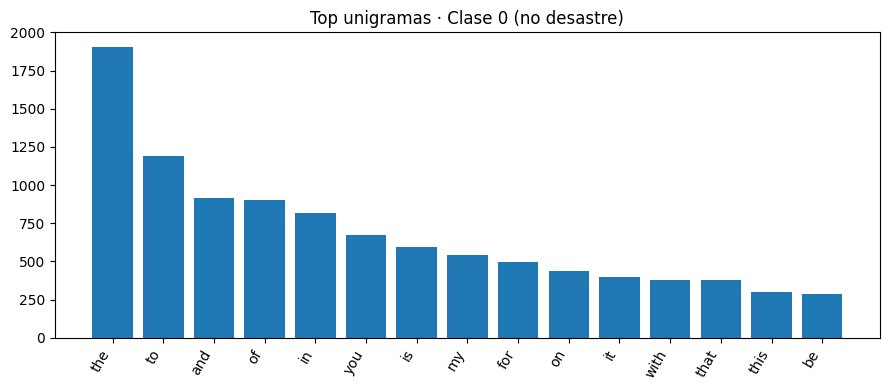

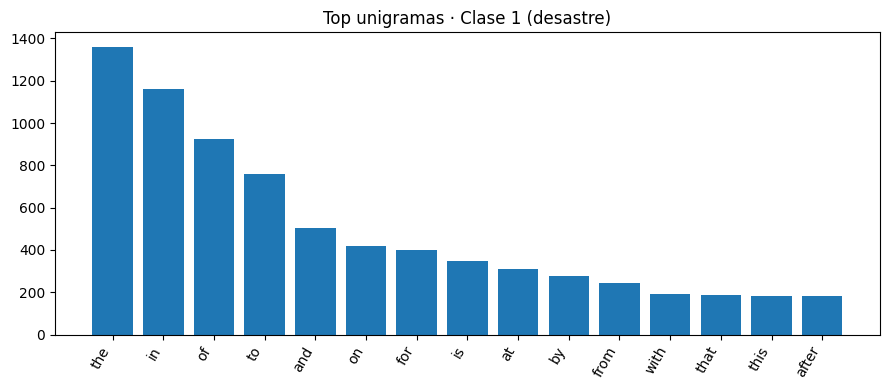

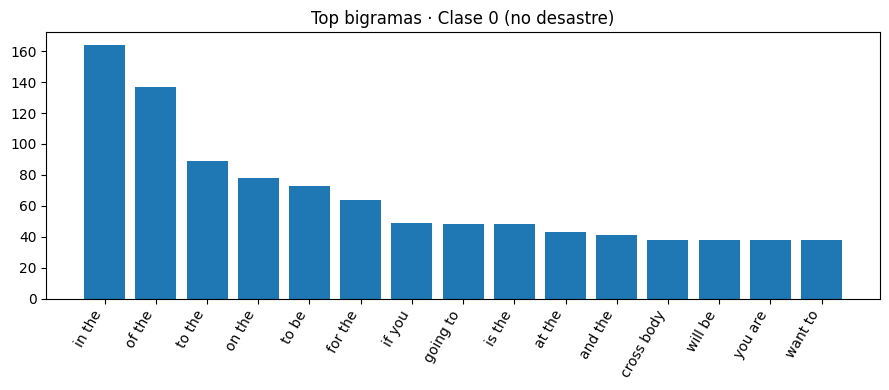

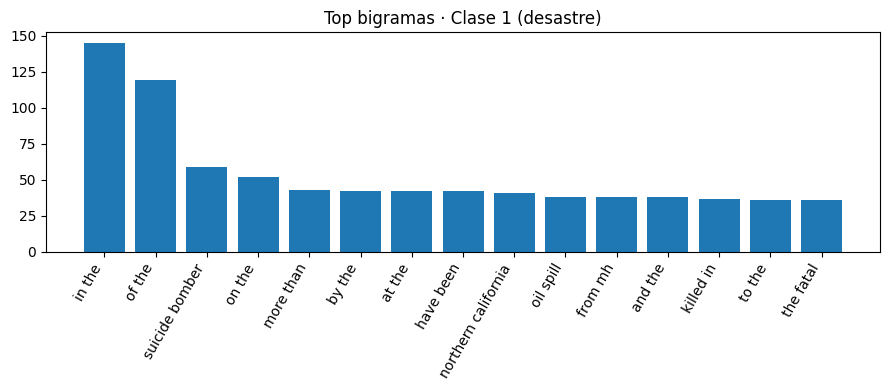

In [10]:
def plot_bar(df_terms: pd.DataFrame, title: str, k=15):
    subset = df_terms.head(k)
    plt.figure(figsize=(9, 4))
    plt.bar(range(len(subset)), subset["freq"])
    plt.xticks(range(len(subset)), subset["term"], rotation=60, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()
plot_bar(top_uni_0, "Top unigramas · Clase 0 (no desastre)")
plot_bar(top_uni_1, "Top unigramas · Clase 1 (desastre)")
plot_bar(top_bi_0, "Top bigramas · Clase 0 (no desastre)")
plot_bar(top_bi_1, "Top bigramas · Clase 1 (desastre)")


## WordCloud por clase (unigramas)

Visualizaremos nubes de palabras separadas por clase (`target = 0` no-desastre, `target = 1` desastre).
La nube pondera el tamaño por **frecuencia de aparición** de cada término (unigrama) tras la limpieza y la
tokenización. Esto sirve para detectar señales léxicas dominantes en cada clase.

**Notas:**
- Usamos `df["tokens"]` (stopwords ya filtradas).
- `collocations=False` evita juntar frases automáticamente (nos interesa cada token por separado).
- Si notas problemas con acentos o símbolos, puedes pasar un `font_path` a `WordCloud(...)`.


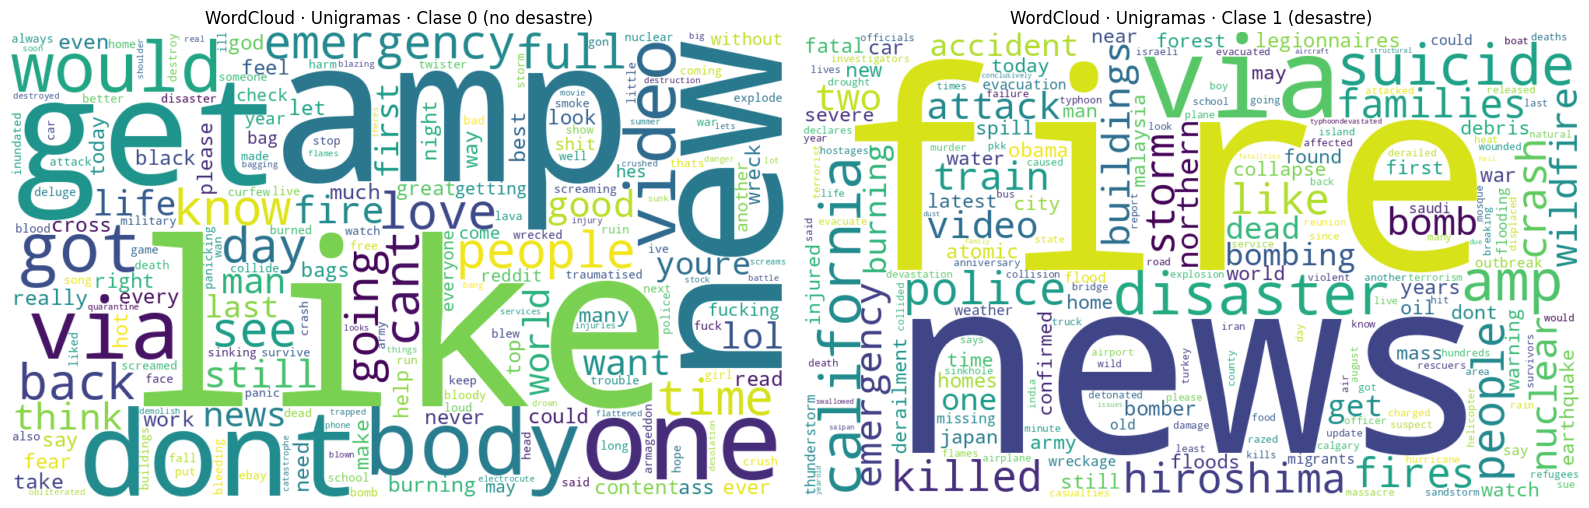

In [11]:
from wordcloud import WordCloud
from collections import Counter

assert "tokens" in df.columns, "Primero ejecuta la limpieza y tokenización (df['tokens'])."

def tokens_series_to_freq(tokens_series) -> Counter:
    """
    Convierte una serie de listas de tokens en un Counter de frecuencias.
    """
    bag = []
    for toks in tokens_series:
        if isinstance(toks, (list, tuple)):
            bag.extend(toks)
    return Counter(bag)

freq_uni_0 = tokens_series_to_freq(df.loc[df.target == 0, "tokens"])
freq_uni_1 = tokens_series_to_freq(df.loc[df.target == 1, "tokens"])

wc_params = dict(
    width=1000,
    height=600,
    background_color="white",
    collocations=False,   
    max_words=200
)

wc0 = WordCloud(**wc_params).generate_from_frequencies(freq_uni_0)
wc1 = WordCloud(**wc_params).generate_from_frequencies(freq_uni_1)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
axes[0].imshow(wc0, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("WordCloud · Unigramas · Clase 0 (no desastre)")

axes[1].imshow(wc1, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("WordCloud · Unigramas · Clase 1 (desastre)")

plt.tight_layout()
plt.show()


## WordCloud por clase (bigramas)

Para resaltar **frases frecuentes** (dos palabras), construiremos bigramas desde `df["tokens"]`
y graficaremos su WordCloud por clase. Esto complementa las tablas de top-bigramas.


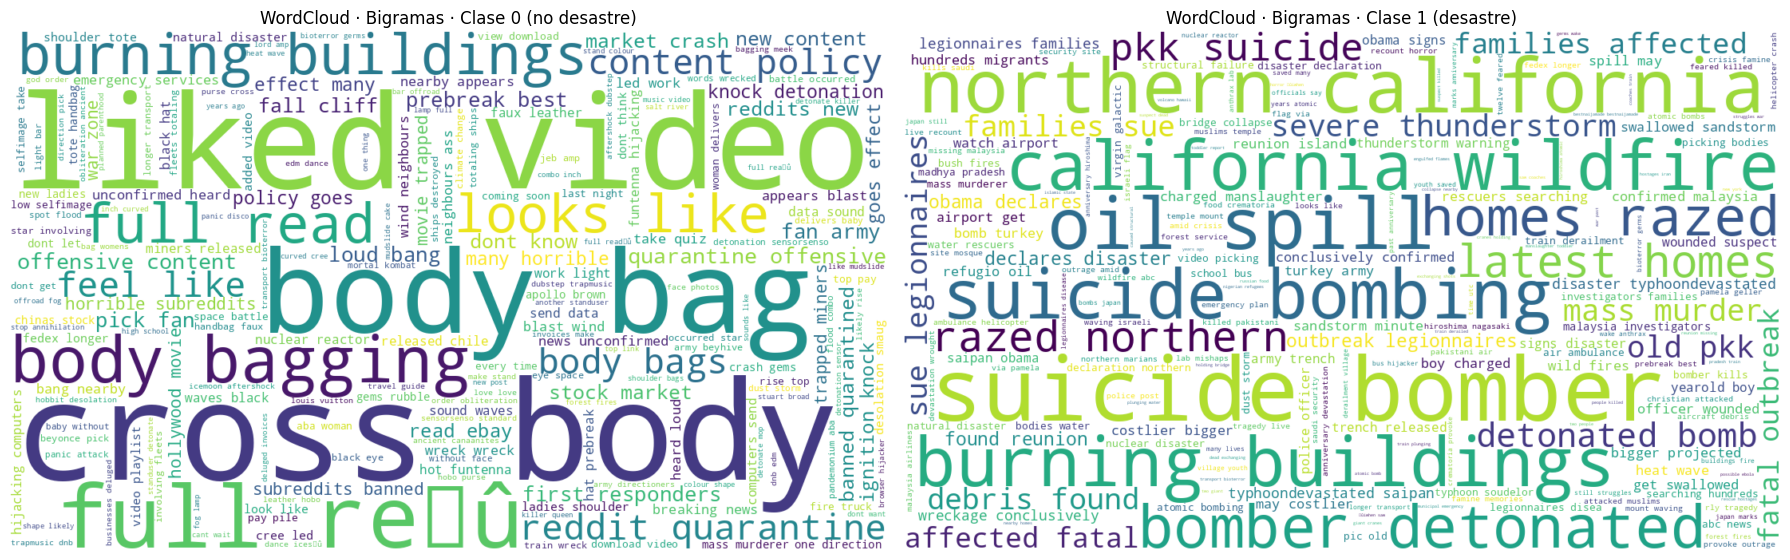

In [12]:
from collections import Counter

def tokens_to_bigrams(tokens):
    """
    Recibe una lista de tokens y devuelve una lista de bigramas como strings "w1 w2".
    """
    if not isinstance(tokens, (list, tuple)) or len(tokens) < 2:
        return []
    return [f"{tokens[i]} {tokens[i+1]}" for i in range(len(tokens)-1)]

def series_to_bigram_freq(tokens_series) -> Counter:
    bag = []
    for toks in tokens_series:
        bag.extend(tokens_to_bigrams(toks))
    return Counter(bag)

freq_bi_0 = series_to_bigram_freq(df.loc[df.target == 0, "tokens"])
freq_bi_1 = series_to_bigram_freq(df.loc[df.target == 1, "tokens"])

wc_bi_params = dict(
    width=1100,
    height=650,
    background_color="white",
    collocations=False,
    max_words=200
)

wc_bi0 = WordCloud(**wc_bi_params).generate_from_frequencies(freq_bi_0)
wc_bi1 = WordCloud(**wc_bi_params).generate_from_frequencies(freq_bi_1)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes[0].imshow(wc_bi0, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("WordCloud · Bigramas · Clase 0 (no desastre)")

axes[1].imshow(wc_bi1, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("WordCloud · Bigramas · Clase 1 (desastre)")

plt.tight_layout()
plt.show()
